In [1]:
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pylab as plt
import my_funs


dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/"
out_dir = "/data/home/hamiddashti/hamid/nasa_above/greeness/working/"

lai_growing = xr.open_dataarray(dir+"data/processed_data/noaa_nc/lai_fapar/resampled/lai_growing_mean.nc")
lai_growing = lai_growing.rename({"latitude":"lat","longitude":"lon"})

lai_growing_trend_ds = xr.open_dataset(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend.nc"
)
lai_growing_trend = lai_growing_trend_ds["trend"]
lai_growing_trend_total = lai_growing_trend.where(
    lai_growing_trend_ds["h"] == 1
)  # where trend is sigificant


percent_cover = (
    xr.open_dataarray(dir + "data/processed_data/percent_cover/percent_cover.nc") * 100
)

# # There is a tiny difference between lat and lon of the dataset due to rounding
# # We make them equal
percent_cover["lat"] = lai_growing_trend_total["lat"]
percent_cover["lon"] = lai_growing_trend_total["lon"]
percent_cover = percent_cover.loc["1984":"2013"]
percent_cover = percent_cover.round(4)

# If a class is 0 change it no nan to prevent false zeros in diff later
percent_cover = percent_cover.where(percent_cover != 0)

t_n = percent_cover.shape[0]
band_n = percent_cover.shape[1]
lat_n = percent_cover.shape[2]
lon_n = percent_cover.shape[3]
n_total = np.isfinite(lai_growing.isel(time=0)).sum()

KeyboardInterrupt: 

In [2]:
# Some setting
winsize = 7  # Window size to search for stable pixels around a central pixel
thresh = (
    2  # Threshold to consider a change in ladn cover happended over the past 30 years
)

lai_growing_trend_nv, lai_growing_trend_lcc, changed_pixels = my_funs.estimate_lcc_trend(
    percent_cover, lai_growing_trend_total, thresh, winsize
)
lai_growing_changed = lai_growing.where(changed_pixels)


In [30]:
lai_growing_trend_nv.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_nv.nc"
)
lai_growing_trend_lcc.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_lcc.nc"
)
lai_growing_trend_total.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_total.nc"
)
lai_growing_changed.to_netcdf(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_changed.nc"
)
changed_pixels.to_netcdf(dir + "data/processed_data/noaa_nc/lai_fapar/trend/changed_pixels.nc")

In [4]:
lai_growing_trend_nv =xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_nv.nc"
)
lai_growing_trend_lcc = xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_lcc.nc"
)
lai_growing_trend_total= xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_trend_total.nc"
)
lai_growing_changed= xr.open_dataarray(
    dir + "data/processed_data/noaa_nc/lai_fapar/trend/lai_growing_changed.nc"
)
changed_pixels=xr.open_dataarray(dir + "data/processed_data/noaa_nc/lai_fapar/trend/changed_pixels.nc")

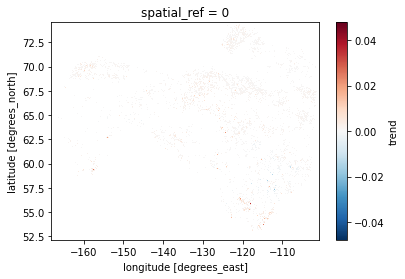

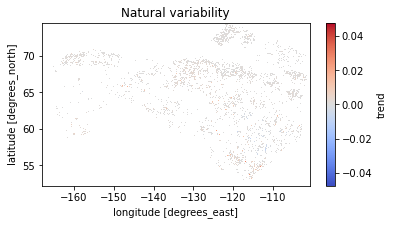

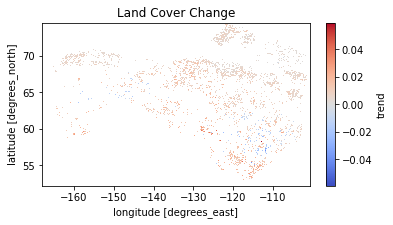

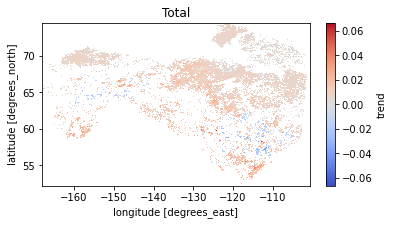

In [12]:
from matplotlib import cm
import matplotlib.colors as colors
cmap = cm.coolwarm

plt.figure(figsize=(6,3))
lai_growing_trend_nv.plot(cmap = cmap, norm=colors.CenteredNorm())
plt.title("Natural variability")
plt.savefig(out_dir+"Figures/lai_growing_trend_nv.png")

plt.figure(figsize=(6,3))
lai_growing_trend_lcc.plot(cmap = cmap, norm=colors.CenteredNorm())
plt.title("Land Cover Change")
plt.savefig(out_dir+"Figures/lai_growing_trend_lcc.png")

plt.figure(figsize=(6,3))
lai_growing_trend_total.plot(cmap = cmap, norm=colors.CenteredNorm())
plt.title("Total")
plt.savefig(out_dir+"Figures/lai_growing_trend_total.png")

Some statistics

In [93]:
from my_funs import isfinite

n_total_sig = np.isfinite(lai_growing_trend_total).sum()
n_lcc_sig = np.isfinite(lai_growing_trend_lcc).sum()


n_sig = (n_total_sig/ n_total).values * 100
n_lcc_nv_region = (np.isfinite(lai_growing_trend_lcc).sum() / n_total).values * 100
n_lcc_nv_n_sig = (
    np.isfinite(lai_growing_trend_lcc).sum()
    / np.isfinite(lai_growing_trend_total).sum()
).values * 100

total_green = lai_growing_trend_total.where(lai_growing_trend_total>0)
total_brown = lai_growing_trend_total.where(lai_growing_trend_total<0)

nv_green = lai_growing_trend_nv.where(lai_growing_trend_nv>0)
nv_brown = lai_growing_trend_nv.where(lai_growing_trend_nv<0)
nv_zero = lai_growing_trend_nv.where(lai_growing_trend_nv==0)


lcc_green = lai_growing_trend_lcc.where(lai_growing_trend_lcc>0)
lcc_brown = lai_growing_trend_lcc.where(lai_growing_trend_lcc<0)

print("percent total greenig:" + str((np.isfinite(total_green).sum()*100/n_total_sig).values))
print("percent total browning:" + str((np.isfinite(total_brown).sum()*100/n_total_sig).values))
print("contribution of LCC: "+ str((n_lcc_sig/n_total_sig).values*100))
print("lcc greening: "+str((np.isfinite(lcc_green).sum()/n_lcc_sig).values*100))
print("lcc browning: "+str((np.isfinite(lcc_brown).sum()/n_lcc_sig).values*100))
print("nv greening: "+str((np.isfinite(nv_green).sum()/n_lcc_sig).values*100))
print("nv browning: "+str((np.isfinite(lcc_brown).sum()/n_lcc_sig).values*100))


percent total greenig:93.0474397369987
percent total browning:6.952560263001297
contribution of LCC: 31.745505272707764
lcc greening: 92.43131952553622
lcc browning: 7.568680474463769
nv greening: 79.32210681580727
nv browning: 7.568680474463769


Calculate natural variability 

In [94]:
greened = lai_growing_trend_lcc>0
ls_green = np.argwhere(greened.values)
percent_cover_green = percent_cover.where(greened)
percent_cover_diff = percent_cover.diff("time")
print(len(ls_green))

30079


In [95]:
lcc_max = []
eps = []
for i in range(len(ls_green)):
    lcc_max.append(percent_cover_diff.isel(lat = ls_green[i][0],lon=ls_green[i][1]).values.max())
    eps.append(lai_growing_trend_lcc.isel(lat = ls_green[i][0],lon=ls_green[i][1]).values)
lcc_max = np.array(lcc_max)
eps = np.array(eps)



In [68]:
# plt.scatter(lcc_max,eps)
lcc_max = lcc_max
eps = eps
I = np.isfinite(lcc_max)

In [75]:
lcc_max_clean = lcc_max[I].reshape(-1,1)
eps_clean = eps[I]

In [76]:
lcc_max_clean.shape

(2317, 1)

In [77]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(lcc_max_clean,eps_clean)

In [78]:
pred = np.squeeze(reg.predict(lcc_max_clean))

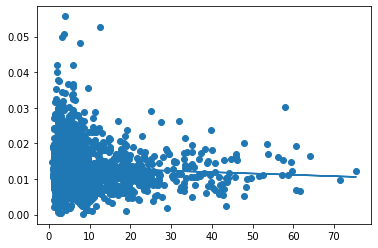

In [80]:
plt.scatter(lcc_max_clean,eps_clean)
plt.plot(np.squeeze(lcc_max_clean),pred)

<AxesSubplot:xlabel='time'>

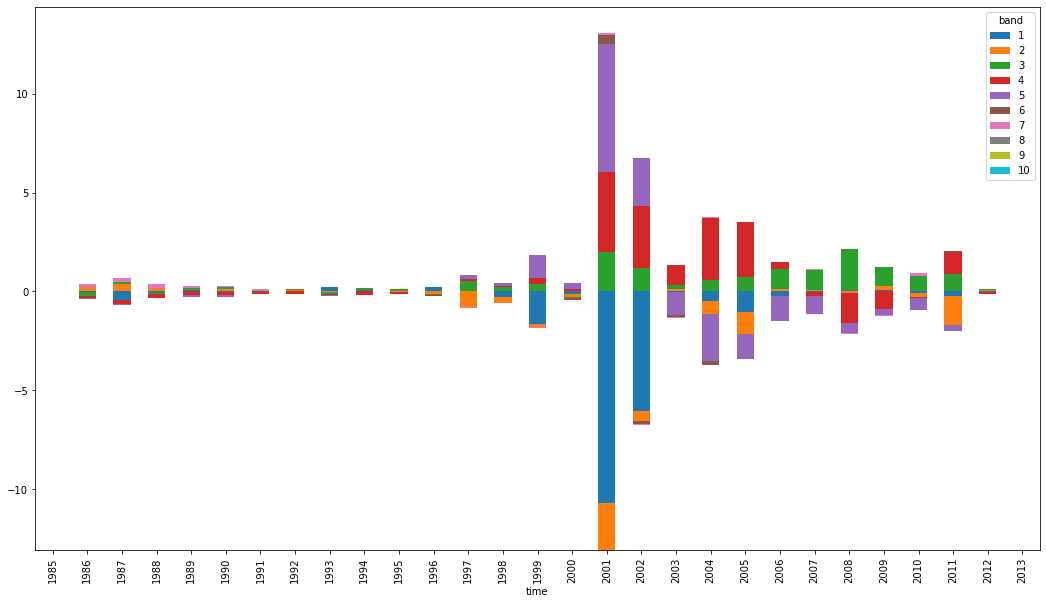

In [286]:
a = percent_cover_green.isel(lat=427,lon=1025)
a_diff = a.diff("time")
lcc_max = abs(a_diff).max()
a_diff.to_pandas().plot(kind="bar",stacked=True,figsize=(18,10))

<AxesSubplot:xlabel='time'>

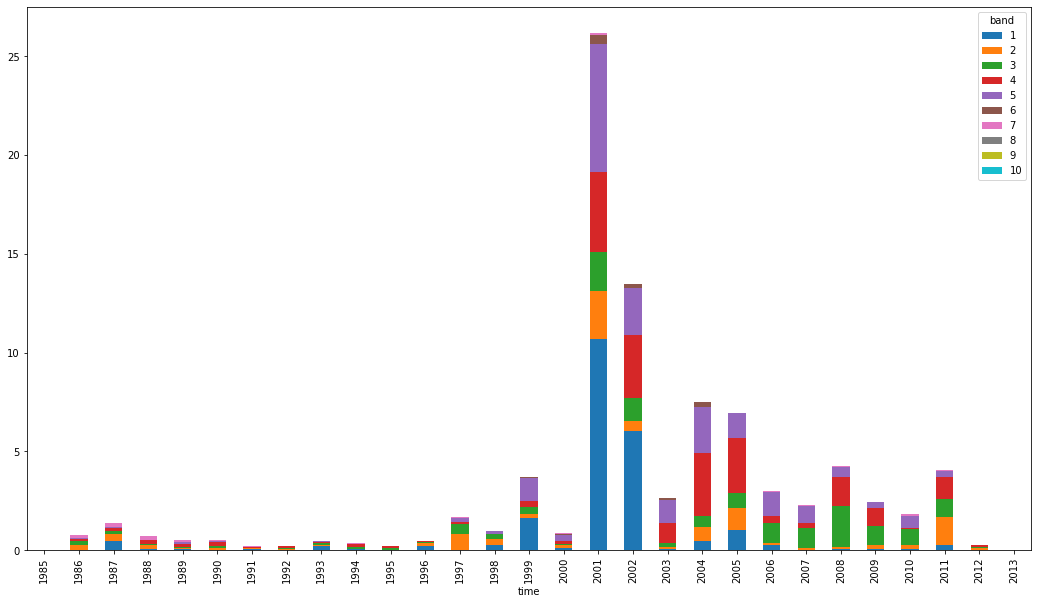

In [282]:
for in 


In [204]:
tmp = percent_cover_green.isel(band=0)
allnan = (~np.isnan(tmp).all(axis=0))
ls = np.argwhere(allnan.values)
ls

array([[   3,  928],
       [   4,  929],
       [   5,  877],
       ...,
       [ 427, 1025],
       [ 427, 1027],
       [ 428, 1047]])

In [238]:

ef_green = []
for i in range(len(ls)):
    ef_green.append(percent_cover_green.isel(band=2,lat=ls[i][0],lon=ls[i][1]).values)
ef_green = np.array(ef_green).transpose()



In [239]:
x=pd.date_range("1984","2014",freq="Y").year
df=pd.DataFrame(ef_green,index=x)


KeyboardInterrupt: 

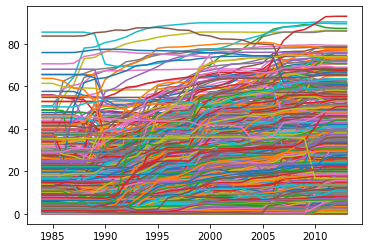

In [244]:
for i in range(5000):
    df.iloc[:,i].plot()

In [241]:
df

,0,1,2,3,4,5,6,7,8,9,...,6330,6331,6332,6333,6334,6335,6336,6337,6338,6339
1984,9.3359,19.423401,0.9176,1.6028,0.2735,18.839100,1.7211,0.7951,0.1677,0.7894,...,4.203900,21.397100,12.898000,2.567800,26.404600,13.149200,15.829600,9.140500,4.081600,12.0866
1985,9.3359,19.423401,0.9176,1.6028,0.2735,18.839100,1.7211,0.7951,0.1677,0.7894,...,4.203900,21.397100,12.898000,2.567800,26.404600,13.149200,15.829600,9.140500,4.081600,12.0754
1986,9.3359,19.423401,0.9176,1.6028,0.2735,18.839100,1.7211,0.7951,0.1677,0.7894,...,4.252600,20.008801,12.605200,2.512000,34.747501,12.302200,15.807300,8.951000,4.103900,11.5940
1987,9.3359,19.423401,0.9176,1.6028,0.2735,18.839100,1.7211,0.7951,0.1677,0.7894,...,4.382300,19.273100,12.808300,2.445100,35.444099,11.987800,16.319099,9.067200,4.157200,10.6441
1988,9.3359,19.445700,0.9176,1.6028,0.2735,18.961700,1.7322,0.7951,0.1788,0.7894,...,4.326600,18.653299,13.786400,2.095700,36.656898,12.074900,16.830900,9.033800,4.028300,9.7428
1989,9.1910,19.389999,0.9176,1.5917,0.3181,18.850201,1.6765,0.8117,0.1561,0.7782,...,5.159600,18.653299,13.761700,2.039900,38.270000,11.820900,17.147200,9.103100,3.983700,9.5580
1990,7.3664,19.027000,0.5497,1.0857,0.3760,18.545500,1.1523,0.7692,0.0780,0.1817,...,6.194800,18.962999,13.860500,2.028800,37.459400,11.285000,17.343000,9.214600,3.939100,9.7348
1991,7.0596,18.386299,0.5497,1.0745,0.3760,18.082500,1.1300,0.7580,0.0780,0.1817,...,6.180600,19.177900,13.894000,2.102100,37.390800,10.571500,17.665800,9.214600,3.961400,9.7516
1992,4.5369,12.794200,0.3021,0.6566,0.5648,17.129801,0.7621,0.5908,0.0669,0.1706,...,6.311400,19.257601,13.923300,2.351300,36.417000,9.827000,17.807501,9.270300,3.950200,9.6228
1993,4.6818,12.368000,0.3467,0.6335,0.4919,16.516701,0.8962,0.3547,0.0669,0.1817,...,5.366900,19.518900,14.843000,2.652200,37.119301,9.753000,17.387400,9.187500,3.972500,9.6133


In [52]:
a = percent_cover.where(b.shape[0]>0)
b= a.isel(band=0)


In [61]:
allnan = (~np.isnan(b).all(axis=0))

In [74]:
np.argwhere(allnan.values)

array([[   3,  928],
       [   4,  929],
       [   5,  877],
       ...,
       [ 427, 1025],
       [ 427, 1027],
       [ 428, 1047]])

In [76]:
lai_growing_trend_lcc[3,928]

<xarray.DataArray 'trend' ()>
array(0.00960556)
Coordinates:
    lat          float32 74.38
    lon          float32 -121.7
    spatial_ref  int64 0